In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from copy import deepcopy
from itertools import product
from scipy.ndimage import gaussian_filter1d

import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys
sys.path.append('../')
from core.models import DenseClassifier, CNNClassifier
from core.initializers import He, Xavier
from core.optimizers import GradDesc, Momentum, Adagrad, RMSProp, Adam
from core.losses import Crossentropy
from core.activations import ReLu, Softmax
from core.metrics import Precision, Recall

## Считывание данных из бинарных файлов

In [3]:
project_path =  Path.cwd().parent
data_path = project_path / "data"
preproc_path = data_path / "preprocessed"

source_train_im_path = preproc_path / "train-images-idx3-ubyte.bin"
source_train_l_path = preproc_path / "train-labels-idx1-ubyte.bin"
source_test_im_path = preproc_path / "t10k-images-idx3-ubyte.bin"
source_test_l_path = preproc_path / "t10k-labels-idx1-ubyte.bin"


### Обучающая выборка

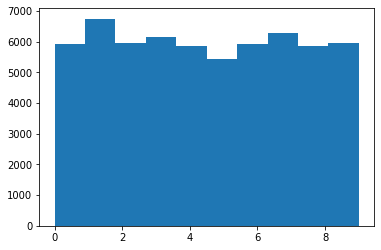

In [4]:
# Метки обуающей выборки
train_labels = np.fromfile(source_train_l_path, dtype=np.uint8, offset=8)
plt.hist(train_labels);

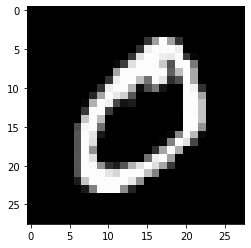

In [5]:
# Изображения обучающей выборки
train_size, rows, columns = 60000, 28, 28
train_images = np.fromfile(source_train_im_path, dtype=np.uint8, offset=16).reshape((train_size, rows, columns))
plt.imshow(train_images[1,:,:], cmap='gray')

### Тестовая выборка

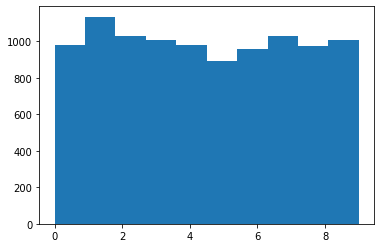

In [6]:
# Метки тестовой выборки
test_labels = np.fromfile(source_test_l_path, dtype=np.uint8, offset=8)
plt.hist(test_labels);

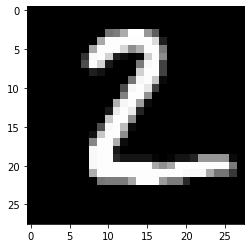

In [7]:
# Изображения тестовой выборки
test_size, rows, columns = 10000, 28, 28
test_images = np.fromfile(source_test_im_path, dtype=np.uint8, offset=16).reshape((test_size, rows, columns))
plt.imshow(test_images[1,:,:], cmap='gray')

## Исследование моделей с полносвязными слоями 

In [9]:
n_train = 60000
n_classes = 10
# Обучающая выборка
prepared_labels = train_labels[:n_train]
prepared_images = train_images[:n_train].reshape(n_train, -1)
prepared_images = (prepared_images > 0).astype(np.uint8)
# Тестовая выборка
prepared_t_labels = test_labels
prepared_t_images = test_images.reshape(test_size, -1)
prepared_t_images = (prepared_t_images > 0).astype(np.uint8)

### Обучение моделей

In [10]:
legend = []
models = dict()
loss_histories = dict()
optimisers_hub = {
    "GradDesc": GradDesc(0.01),
    "Momentum": Momentum(learning_rate=0.001, momentum=0.9),
    "Adagrad": Adagrad(0.001),
    "RMSProp": RMSProp(10**(-3), momentum=0.9),
    "Adam": Adam(10**(-3), momentum_1=0.9, momentum_2=0.9)
}
metrics = [Precision(), Recall()]

for is_batch_norm, (label, optimiser) in product([True, False], optimisers_hub.items()):
    title = f"{label} | {is_batch_norm}" 
    print(f"\n{title}")
    # Создадим модель
    models[title] =(
         DenseClassifier(
            input_size=28*28,
            layers_sizes=[64, 32, 10],
            initializers_classes=[He, He, Xavier],
            activations_classes=[ReLu, ReLu, Softmax],
            optimizer=deepcopy(optimiser),
            loss=Crossentropy,
            need_batch_normaliser=is_batch_norm
        )
    )
    # Обучим модель
    loss_histories[title] = models[title].fit(3, 64, prepared_images, prepared_labels, metrics=metrics, l1=10**(-3), l2=10**(-4))


GradDesc | True
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:12<00:00, 57.91it/s]


Mean loss: 0.44999998807907104
Fit scores: Precision 0.9274 | Recall 0.9274
Validation scores: Precision 0.9263 | Recall 0.9262
Epoch 2


100%|██████████| 750/750 [00:14<00:00, 51.86it/s]


Mean loss: 0.20999999344348907
Fit scores: Precision 0.949 | Recall 0.9487
Validation scores: Precision 0.9373 | Recall 0.9369
Epoch 3


100%|██████████| 750/750 [00:15<00:00, 47.98it/s]


Mean loss: 0.17000000178813934
Fit scores: Precision 0.9585 | Recall 0.9583
Validation scores: Precision 0.9525 | Recall 0.9519

Momentum | True
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:14<00:00, 52.84it/s]


Mean loss: 0.44999998807907104
Fit scores: Precision 0.9319 | Recall 0.9318
Validation scores: Precision 0.9261 | Recall 0.926
Epoch 2


100%|██████████| 750/750 [00:13<00:00, 53.73it/s]


Mean loss: 0.20999999344348907
Fit scores: Precision 0.9487 | Recall 0.9487
Validation scores: Precision 0.9405 | Recall 0.9405
Epoch 3


100%|██████████| 750/750 [00:13<00:00, 56.19it/s]


Mean loss: 0.17000000178813934
Fit scores: Precision 0.9591 | Recall 0.9592
Validation scores: Precision 0.9501 | Recall 0.9505

Adagrad | True
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:19<00:00, 37.63it/s]


Mean loss: 0.75
Fit scores: Precision 0.886 | Recall 0.8851
Validation scores: Precision 0.8848 | Recall 0.884
Epoch 2


100%|██████████| 750/750 [00:19<00:00, 38.89it/s]


Mean loss: 0.5
Fit scores: Precision 0.9051 | Recall 0.9048
Validation scores: Precision 0.9022 | Recall 0.9024
Epoch 3


100%|██████████| 750/750 [00:18<00:00, 39.53it/s]


Mean loss: 0.4300000071525574
Fit scores: Precision 0.9143 | Recall 0.9142
Validation scores: Precision 0.9144 | Recall 0.9147

RMSProp | True
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:18<00:00, 41.16it/s]


Mean loss: 0.3199999928474426
Fit scores: Precision 0.9488 | Recall 0.9482
Validation scores: Precision 0.9426 | Recall 0.9421
Epoch 2


100%|██████████| 750/750 [00:18<00:00, 39.61it/s]


Mean loss: 0.20000000298023224
Fit scores: Precision 0.9454 | Recall 0.9456
Validation scores: Precision 0.9424 | Recall 0.9424
Epoch 3


100%|██████████| 750/750 [00:18<00:00, 40.44it/s]


Mean loss: 0.1899999976158142
Fit scores: Precision 0.9548 | Recall 0.9547
Validation scores: Precision 0.9503 | Recall 0.9504

Adam | True
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:20<00:00, 37.00it/s]


Mean loss: 0.3400000035762787
Fit scores: Precision 0.9502 | Recall 0.9492
Validation scores: Precision 0.9457 | Recall 0.9446
Epoch 2


100%|██████████| 750/750 [00:21<00:00, 35.19it/s]


Mean loss: 0.20000000298023224
Fit scores: Precision 0.9565 | Recall 0.9559
Validation scores: Precision 0.9522 | Recall 0.9512
Epoch 3


100%|██████████| 750/750 [00:21<00:00, 34.60it/s]


Mean loss: 0.18000000715255737
Fit scores: Precision 0.9575 | Recall 0.9574
Validation scores: Precision 0.952 | Recall 0.9522

GradDesc | False
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:08<00:00, 83.35it/s] 


Mean loss: 1.7200000286102295
Fit scores: Precision 0.7778 | Recall 0.7723
Validation scores: Precision 0.7816 | Recall 0.7766
Epoch 2


100%|██████████| 750/750 [00:08<00:00, 91.11it/s] 


Mean loss: 0.6299999952316284
Fit scores: Precision 0.8597 | Recall 0.8569
Validation scores: Precision 0.8586 | Recall 0.8563
Epoch 3


100%|██████████| 750/750 [00:07<00:00, 99.29it/s] 


Mean loss: 0.4699999988079071
Fit scores: Precision 0.8763 | Recall 0.8756
Validation scores: Precision 0.8806 | Recall 0.8799

Momentum | False
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:09<00:00, 77.99it/s] 


Mean loss: 1.659999966621399
Fit scores: Precision 0.7801 | Recall 0.7748
Validation scores: Precision 0.7772 | Recall 0.7724
Epoch 2


100%|██████████| 750/750 [00:07<00:00, 96.33it/s] 


Mean loss: 0.6499999761581421
Fit scores: Precision 0.8534 | Recall 0.853
Validation scores: Precision 0.8535 | Recall 0.8532
Epoch 3


100%|██████████| 750/750 [00:07<00:00, 97.21it/s] 


Mean loss: 0.47999998927116394
Fit scores: Precision 0.8758 | Recall 0.8748
Validation scores: Precision 0.877 | Recall 0.8763

Adagrad | False
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:13<00:00, 54.09it/s]


Mean loss: 1.3799999952316284
Fit scores: Precision 0.7938 | Recall 0.7785
Validation scores: Precision 0.7992 | Recall 0.7869
Epoch 2


100%|██████████| 750/750 [00:13<00:00, 54.48it/s] 


Mean loss: 0.8299999833106995
Fit scores: Precision 0.8226 | Recall 0.8132
Validation scores: Precision 0.8233 | Recall 0.8146
Epoch 3


100%|██████████| 750/750 [00:13<00:00, 55.00it/s]


Mean loss: 0.699999988079071
Fit scores: Precision 0.8373 | Recall 0.8318
Validation scores: Precision 0.843 | Recall 0.8378

RMSProp | False
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:15<00:00, 48.35it/s]


Mean loss: 0.6000000238418579
Fit scores: Precision 0.8847 | Recall 0.8803
Validation scores: Precision 0.8794 | Recall 0.8747
Epoch 2


100%|██████████| 750/750 [00:15<00:00, 49.15it/s]


Mean loss: 0.3700000047683716
Fit scores: Precision 0.8987 | Recall 0.8953
Validation scores: Precision 0.9017 | Recall 0.8986
Epoch 3


100%|██████████| 750/750 [00:13<00:00, 57.10it/s]


Mean loss: 0.33000001311302185
Fit scores: Precision 0.9065 | Recall 0.9032
Validation scores: Precision 0.9029 | Recall 0.8997

Adam | False
By epoch progress
Epoch 1


100%|██████████| 750/750 [00:14<00:00, 50.06it/s]


Mean loss: 0.5899999737739563
Fit scores: Precision 0.8869 | Recall 0.8839
Validation scores: Precision 0.8868 | Recall 0.8835
Epoch 2


100%|██████████| 750/750 [00:16<00:00, 44.13it/s]


Mean loss: 0.3799999952316284
Fit scores: Precision 0.9015 | Recall 0.9013
Validation scores: Precision 0.9017 | Recall 0.9018
Epoch 3


100%|██████████| 750/750 [00:15<00:00, 47.02it/s]


Mean loss: 0.33000001311302185
Fit scores: Precision 0.9066 | Recall 0.9021
Validation scores: Precision 0.9058 | Recall 0.9011


### Сравнение моделей при обучении

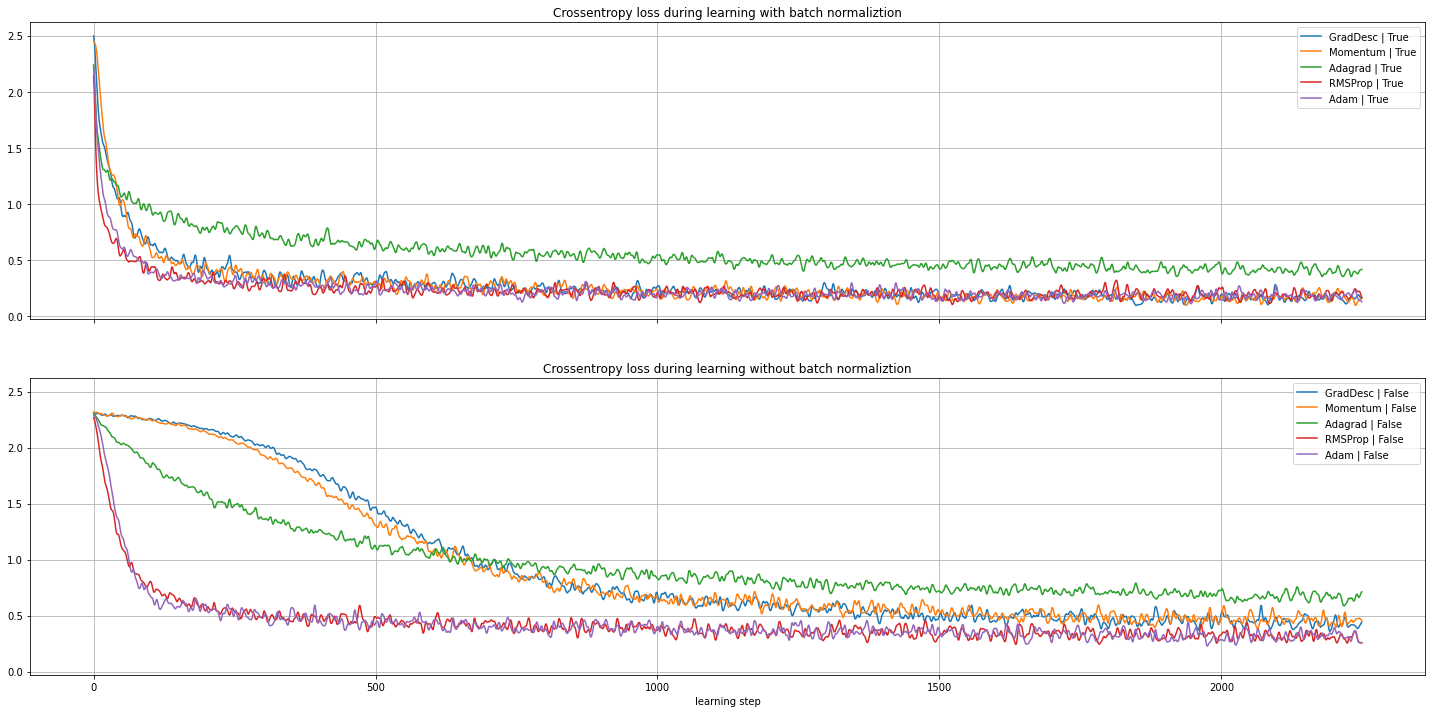

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(25,12))
legend = [[],[]]

for label, loss in loss_histories.items():
    ind = 0 if "True" in label else 1
    curve = gaussian_filter1d(loss.flatten(), sigma=2)
    legend[ind].append(label)
    ax[ind].plot(curve)
for i in range(2):
    ax[i].grid()
    ax[i].legend(legend[i])
    if i < 1:
        ax[i].set_title("Crossentropy loss during learning with batch normaliztion");
    else:
        ax[i].set_title("Crossentropy loss during learning without batch normaliztion");
plt.xlabel("learning step");

### Сравнение метрик моделей на тесте

In [56]:
scores = []
for title, model in models.items(): 
    optimiser, is_batch_norm = title.split(" | ")
    is_batch_norm = True if is_batch_norm == "True" else False
    test_prediction = model.predict(prepared_t_images)
    for m in metrics:
        tmp_dict = {"Optimiser": optimiser,
                "Is batch norm": "Use" if is_batch_norm else "Not use"}
        tmp_dict["Metric"] = m.__class__.__name__
        tmp_dict["Score"] = (
            round(m.calc(prepared_t_labels, test_prediction), 4)
        )    
        scores.append(tmp_dict)

In [65]:
scores_df = pd.DataFrame(scores)
scores_df.sort_values(by=["Score"], inplace=True)
px.scatter(
    scores_df,
    x="Optimiser",
    y="Is batch norm",
    facet_row="Metric",
    color="Score",
    template="plotly_dark",
    title="Models test scores",
    size="Score",
).show()

## Исследование модели со сверточными слоями

In [8]:
n_train = 40000
n_classes = 10
# Обучающая выборка
prepared_labels = train_labels[:n_train]
prepared_images = np.expand_dims(train_images[:n_train], axis=-1)
prepared_images = (prepared_images > 0).astype(np.uint8)
# Тестовая выборка
prepared_t_labels = test_labels
prepared_t_images = np.expand_dims(test_images, axis=-1)
prepared_t_images = (prepared_t_images > 0).astype(np.uint8)

### Обучение модели

In [10]:

metrics = [Precision(), Recall()]
model_cnn =(
        CNNClassifier(
        input_shape=(28, 28),
        optimizer=Adam(10**(-2), momentum_1=0.9, momentum_2=0.9),
        loss=Crossentropy,
    )
)
# Обучим модель
loss_cnn = model_cnn.fit(3, 64, prepared_images, prepared_labels, metrics=metrics, val_part=0.2, l1=10**(-3), l2=10**(-4))

32000 64
By epoch progress
Epoch 1


100%|██████████| 500/500 [19:04<00:00,  2.29s/it]


Mean loss: 0.3799999952316284


100%|██████████| 500/500 [16:17<00:00,  1.95s/it]


Fit scores: Precision 0.9062 | Recall 0.9038


100%|██████████| 125/125 [04:04<00:00,  1.96s/it]


Validation scores: Precision 0.8937 | Recall 0.8914
Epoch 2


100%|██████████| 500/500 [18:56<00:00,  2.27s/it]


Mean loss: 0.3100000023841858


100%|██████████| 500/500 [16:46<00:00,  2.01s/it]


Fit scores: Precision 0.9181 | Recall 0.9163


100%|██████████| 125/125 [04:07<00:00,  1.98s/it]


Validation scores: Precision 0.9094 | Recall 0.9073
Epoch 3


100%|██████████| 500/500 [18:47<00:00,  2.26s/it]


Mean loss: 0.30000001192092896


100%|██████████| 500/500 [16:15<00:00,  1.95s/it]


Fit scores: Precision 0.915 | Recall 0.9144


100%|██████████| 125/125 [04:08<00:00,  1.99s/it]

Validation scores: Precision 0.9093 | Recall 0.9093


### Характеристики на обучении

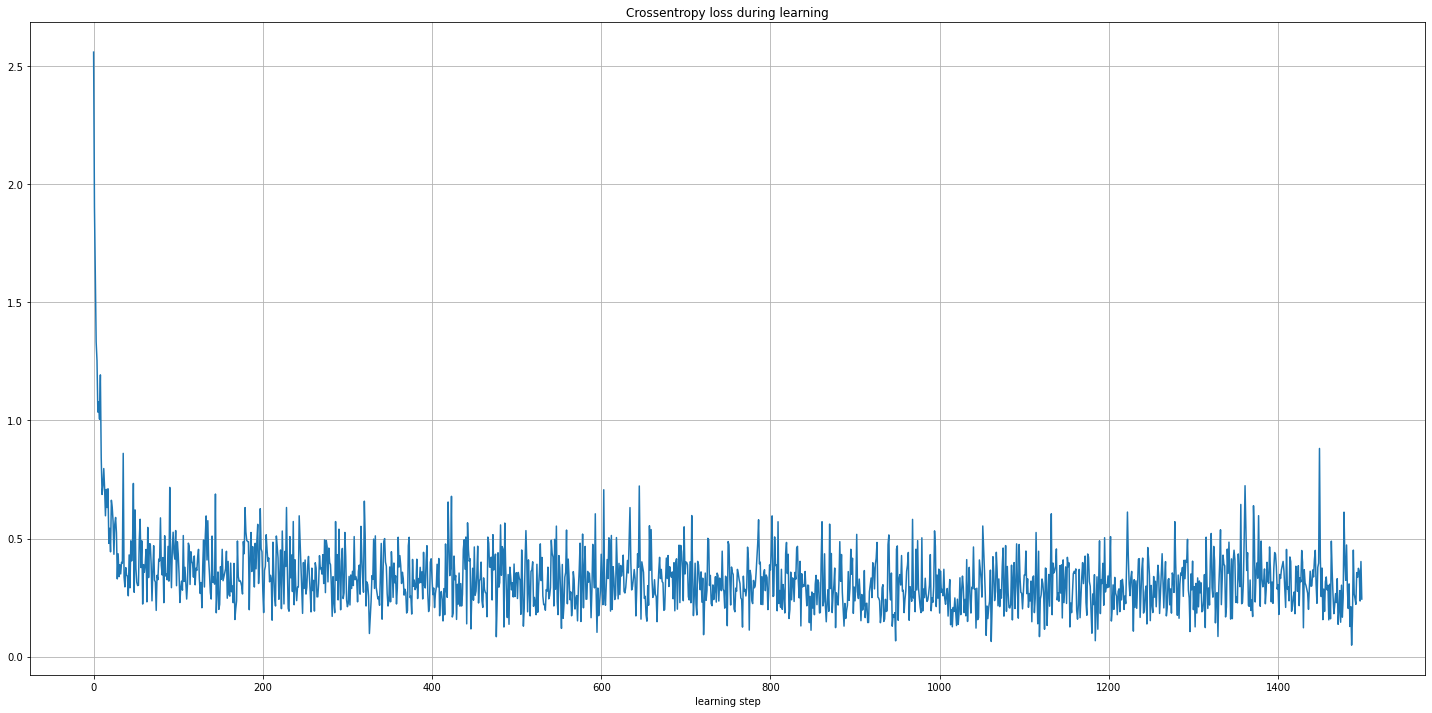

In [11]:
plt.figure(figsize=(25,12))
plt.plot(loss_cnn.flatten())
plt.grid()
plt.title("Crossentropy loss during learning");
plt.xlabel("learning step");

### Метрики на тесте

In [12]:
test_prediction = model_cnn.predict(prepared_t_images)
for m in metrics:
    print(f"{m.__class__.__name__} {round(m.calc(prepared_t_labels, test_prediction), 4)}")    

100%|██████████| 157/157 [05:06<00:00,  1.95s/it]

Precision 0.9175
Recall 0.9166
